In [1]:
# In[1]:
!pip install keras tensorflow scikit-learn numpy

In [2]:

# In[1]:
import pandas as pd

# Load the training and testing data
train_data = pd.read_csv('train_benign.csv')
test_data = pd.read_csv('test_aue1.csv')

In [3]:
# Select the features to be used for the autoencoder
#selected_features = [1, 8, 12, 14, 79, 15, 18, 25, 28, 32, 33, 37, 39, 44, 46, 55, 56]
selected_features = [
    'Dst Port', 'Fwd Packet Length Max', 'Bwd Packet Length Max',
    'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Mean',
    'Fwd IAT Std', 'Bwd IAT Mean', 'Fwd PSH Flags', 'Bwd PSH Flags',
    'Fwd RST Flags', 'Fwd Header Length', 'Packet Length Max',
    'Packet Length Std', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg',
    'ICMP Type'
]
X_train = train_data.loc[:, selected_features]
y_train = train_data['Label']  # Assuming the last column is 'Label'
X_test = test_data.loc[:, selected_features]
y_test = test_data['Label']    # Assuming the last column is 'Label'


In [4]:
# In[5]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

def create_autoencoder(input_dim):
    # Define the sizes of the encoded representations
    encoding_dim_1 = int(input_dim / 2)
    encoding_dim_2 = int(encoding_dim_1 / 2)
    bottleneck_dim = int(encoding_dim_2 / 2)

    # Define input layer
    input_layer = Input(shape=(input_dim,))

    # Define encoding layers
    encoded_1 = Dense(encoding_dim_1, activation='relu')(input_layer)
    encoded_1 = Dropout(0.3)(encoded_1)  # Dropout layer
    encoded_2 = Dense(encoding_dim_2, activation='relu')(encoded_1)
    encoded_2 = Dropout(0.3)(encoded_2)  # Dropout layer
    bottleneck = Dense(bottleneck_dim, activation='relu')(encoded_2)

    # Define decoding layers
    decoded_1 = Dense(encoding_dim_2, activation='relu')(bottleneck)
    decoded_1 = Dropout(0.3)(decoded_1)  # Dropout layer
    decoded_2 = Dense(encoding_dim_1, activation='relu')(decoded_1)
    decoded_2 = Dropout(0.3)(decoded_2)  # Dropout layer
    output_layer = Dense(input_dim, activation='sigmoid')(decoded_2)

    # Combine the layers to create the autoencoder model
    autoencoder = Model(input_layer, output_layer)

    return autoencoder

In [5]:
# In[6]:
# 1. Feature Scaling:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Model Creation and Compilation:
input_dim = X_train_scaled.shape[1]
autoencoder = create_autoencoder(input_dim)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 3. Early Stopping:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Training the Model:
autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled),
                callbacks=[early_stopping])



Epoch 1/50


2023-11-29 03:31:08.885097: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-29 03:31:08.885125: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-29 03:31:08.885136: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-29 03:31:08.885164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-29 03:31:08.885181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-29 03:31:09.349131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-29 03:31:09.387337

1247/1247 [==============================] - 11s 8ms/step - loss: 0.9228 - val_loss: 4.4787
Epoch 2/50
1247/1247 [==============================] - 10s 8ms/step - loss: 0.8511 - val_loss: 4.4318
Epoch 3/50
1247/1247 [==============================] - 10s 8ms/step - loss: 0.8543 - val_loss: 4.4594
Epoch 4/50
1247/1247 [==============================] - 10s 8ms/step - loss: 0.8598 - val_loss: 4.4838
Epoch 5/50
1247/1247 [==============================] - 10s 8ms/step - loss: 0.8626 - val_loss: 4.5194
Epoch 6/50
1247/1247 [==============================] - 10s 8ms/step - loss: 0.8768 - val_loss: 4.5252
Epoch 7/50
1247/1247 [==============================] - 10s 8ms/step - loss: 0.8812 - val_loss: 4.5259


In [6]:
from keras.models import load_model

# Assuming 'autoencoder' is your trained model
autoencoder.save('autoencoder2_model.h5')  # Saves the model

# To load the model later
loaded_autoencoder = load_model('autoencoder2_model.h5')


/Users/christinastodt/anaconda3/envs/AnomalyTest/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# In[7]:
import numpy as np

# Predict the test set
predictions = autoencoder.predict(X_test_scaled)

# Calculate mean squared error between predictions and actual values
mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)


4657/4657 [==============================] - 7s 1ms/step


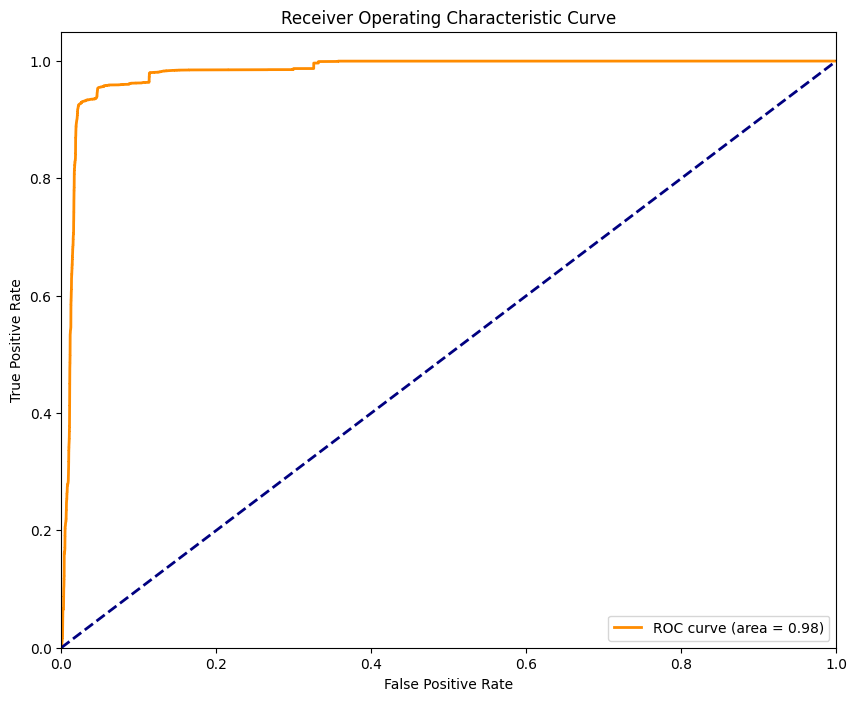

In [8]:
# In[8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse, pos_label='Anomaly')

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [9]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Ensure you use the scaled test data for making predictions
X_test_predictions = autoencoder.predict(X_test_scaled)

# Calculating the mean squared error (reconstruction error) between the original scaled data and their reconstructions
mse = np.mean(np.power(X_test_scaled - X_test_predictions, 2), axis=1)

# Print the mean squared errors
print("Reconstruction error (MSE) for each sample:")
print(mse)
general_mse = np.mean(mse)

# Choose a threshold value for which F1 score is maximized
thresholds = np.linspace(0.1, 10, 200)  # Adjust the range and granularity as needed

# Convert 'y_test' labels to binary format (0 for 'BENIGN' and 1 for 'Anomaly')
y_test_binary = (y_test == 'Anomaly').astype(int)

f1_scores = [f1_score(y_test_binary, mse > threshold) for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Predicting anomalies using the optimal threshold
y_pred = (mse > optimal_threshold).astype(int)

# Calculating F1 score and accuracy based on the reconstruction error
f1 = f1_score(y_test_binary, y_pred)
accuracy = accuracy_score(y_test_binary, y_pred)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"General MSE: {general_mse}")


4657/4657 [==============================] - 7s 1ms/step
Reconstruction error (MSE) for each sample:
[ 1.08188722  4.07469176  2.12867667 ...  0.21173111  0.74773639
 10.49519385]
Optimal Threshold: 4.826130653266332
F1 Score: 0.9415717681198156
Accuracy: 0.9589175330384649
General MSE: 4.4318392055475035


In [10]:
from keras.models import load_model
import numpy as np

# ... (your code for loading data and model)

# Predict the reconstruction of the training set
reconstructed_train = autoencoder.predict(X_train_scaled)

# Compute MSE for each training sample
mse_train = np.mean(np.power(X_train_scaled - reconstructed_train, 2), axis=1)

# Print training MSE
print("Training MSE for each sample:")
print(mse_train)

# Set the threshold as mean plus 2 standard deviations of the training MSE
threshold = np.mean(mse_train) + 2 * np.std(mse_train)

# Predict the reconstruction of the test set
reconstructed_test = autoencoder.predict(X_test_scaled)

# Compute MSE for each test sample
mse_test = np.mean(np.power(X_test_scaled - reconstructed_test, 2), axis=1)

# Print test MSE
print("\nTest MSE for each sample:")
print(mse_test)

# Print the reconstruction threshold
print("\nReconstruction error threshold:")
print(threshold)

# Anything that has a reconstruction error above this threshold is considered an anomaly
anomalies = mse_test > threshold

# Print out the results
print("\nNumber of anomalies detected:", np.sum(anomalies))
print("Indices of anomaly samples:", np.where(anomalies)[0])

9973/9973 [==============================] - 14s 1ms/step
Training MSE for each sample:
[0.21412516 0.21412605 0.21411176 ... 0.34352472 0.15682309 0.1118087 ]
4657/4657 [==============================] - 7s 1ms/step

Test MSE for each sample:
[ 1.08188722  4.07469176  2.12867667 ...  0.21173111  0.74773639
 10.49519385]

Reconstruction error threshold:
31.324607548483684

Number of anomalies detected: 1091
Indices of anomaly samples: [   119    435    498 ... 148515 148962 148988]


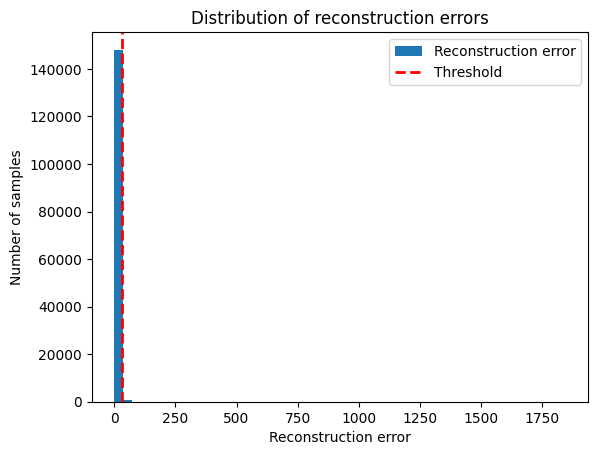

In [11]:
import matplotlib.pyplot as plt

plt.hist(mse_test, bins=50, label='Reconstruction error')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Threshold')
plt.title('Distribution of reconstruction errors')
plt.xlabel('Reconstruction error')
plt.ylabel('Number of samples')
plt.legend()